## Optimizing Frogger: Q-Learning Strategies

In this notebook we will apply the Epsilon-Greedy Q-learning algorithm to the Frogger Atari game.  We have been inspired by the work done in [2] - and hope to implement the Epsilon-Greedy Q-learning algorithm to play Frogger.

From [1] we can see that the Q-learning update formula is

$$
Q(s, a) = Q(s, a) + \alpha \left[ r + \gamma \max_{a'} Q(s', a') - Q(s, a) \right]
$$

Where we have the below:

Q(s,a) is the Q-value representing the expected cumulative rewards for taking action a from state s.

Alpha is the learning rate which controls the step size of the Q-value updates.

r is the immediate reward obtained after taking action a from state s.

Gamma is the discount factor representing the importance of future rewards.  This value is typically between 0 and 1.

s' is the next state after taking action a from state s.

a' is the action that maximizes the Q-value in the next state s'.

One of the key components of a Reinforcement Learning algorithm is finding a trade off between exploration and exploitation.  In this work we utilize the epsilon-greedy strategy which is defined as follows:

$$
\pi(a|s) = 
\begin{cases} 
\frac{\epsilon}{\text{num_actions}} + (1 - \epsilon), & \text{if } a^* = \text{argmax}_a Q(s, a) \\
\frac{\epsilon}{\text{num_actions}}, & \text{otherwise}
\end{cases}
$$

To implement a Q-learning based approach to "solving" Frogger we will need the following "ingredients"

1) State Space - This is the set of all possible states in the environment.

2) Action Space - This is the set of all possible actions that the agent can take in the environment.

3) Reward Function - This is a function that defines the immediate reward that the agent receives after taking a particular action from a specific state.

4) Q-Value Function - This is the function that estimates the expected cumulative rewards for taking a particular action a from a state s.

5) Learning Rate - This is a parameter that controls the step size or the rate that the Q-values are updated during the learning process.

6) Discount Factor - This is a parameter that determines the importance of future rewards in the Q-value updates.

7) Exploration-Exploitation Strategy - Policy that defines how the agent selects actions in each state, for this research we will use the epsilon-greedy strategy defined above.

8) Initialization of Q-Values - Initialize Q-values for all state-action pairs.

9) Q-Learning Update Rule - Formula that updates the Q-values based on observed rewards and the Q-values of future states.

10) Termination Condition - Determines when to stop the learning process.

11) Learning Algorithm - Overall procedure that combines all of the above to iteratively update the Q-values and improve the agent's policy over time.

In the below we will examine each of these more closely with how it applies to the game of Frogger.

Let's take a look at the actions the agent will be able to take in Frogger.

In [36]:
# OpenAI gym
import gymnasium as gym
# We are going to take a screenshot of the environment
from PIL import Image

# Create MsPacman environment
env = gym.make("ALE/Frogger-ram-v5", render_mode="rgb_array")

# Show actions
env.env.unwrapped.get_action_meanings()

['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN']

In [37]:
# Lets take a look at a random state for the agent
state = env.reset()
print(state)

(array([144,  19,   6,  39,   7,  43, 148, 125,  27,  35,  37,  64,  99,
        86, 119,  87,  85,  53, 133,  59, 135, 117, 236,  52,  19, 229,
         3, 165, 172,  43, 180,  37,   5,  55, 233, 200, 154, 184, 216,
       246, 171, 150, 124, 186, 255,  91,  91, 195,  80,   0,   0,   4,
        40,   0,   0,   0, 234, 254, 234, 254,  29, 254,  51, 254, 157,
       254, 157, 254,  84, 254,   1,   0, 115, 115, 149,   0,   0,   0,
         0,   0,   4,   4,   1,   1,   0, 253, 154, 253, 255,   0,   0,
        71,   0,   1,   8,  62,  30,   0,   0,   0,   0,   0,   0,   0,
        46, 253,   0, 115, 255, 198,   1, 255,   0, 163,  58,  80, 255,
        80, 255,  28,  12,   0,   0,  91,   0,   0, 124, 250], dtype=uint8), {'lives': 4, 'episode_frame_number': 0, 'frame_number': 0})


Notice that the agent's state values are pixel values.  Next we'll show the max and min value that the agent can obtain as a reward.

In [38]:
min_reward, max_reward = env.reward_range
print(f"Minimum Reward: {min_reward}")
print(f"Maximum Reward: {max_reward}")

Minimum Reward: -inf
Maximum Reward: inf


Finally, before we implement our algorithm, lets take a look at the agent's environment.



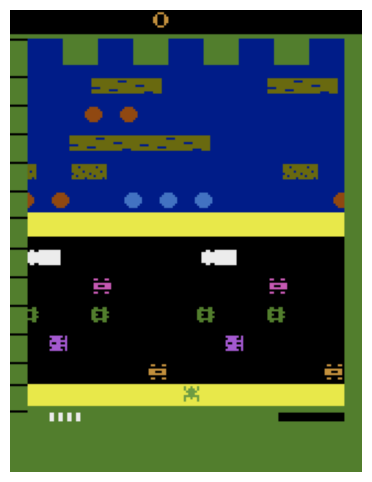

In [39]:
# Helper function to show the environment
import matplotlib.pyplot as plt
def show_environment(env):
    plt.figure(figsize=(8, 6))
    plt.imshow(env.render())
    plt.axis('off')
    plt.show()
show_environment(env)

In the above we can see a screenshot of the Frogger Atari game - this screenshot shows our agent's environment.  Now that we have gone over the agent's environment, potential rewards, and the agent's actions, lets now start looking into implementing an agent for our Q-Learning Algorithm.  The code for the agent can be find in the QAgent.py file.

## Agent Class

In the below we will create a Q-learning Agent class.  Comments have been input throughout to explain what each line of code is doing.

In [40]:
"""
Q-learning agent to play Frogger -

The agent will need the following parameters:
    
    num_actions: int,                 # Number of possible actions the agent can take
    learning_rate: float,             # Learning rate for the Q-learning algorithm
    initial_epsilon: float,           # Initial exploration probability (epsilon-greedy strategy)
    epsilon_decay: float,             # Rate at which epsilon decays over time
    final_epsilon: float,             # Final minimum exploration probability
    discount_factor: float = 0.09,    # Discount factor for future rewards  

The agent class will also include the below functions:
    
    get_action:
        
        Returns the best action with probability (1 - epsilon) otherwise a random
        action with probability epsilon to ensure exploration.
        
    update:
        
        Updates the Q-value of an action based on the observed reward and next state.
        
    decay_epsilon:
        
        Decay the exploration probability (epsilon) over time.
        
"""
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import os

class Agent:
    def __init__(
            self,
            num_actions: int,                 # Number of possible actions the agent can take
            learning_rate: float,             # Learning rate for the Q-learning algorithm
            initial_epsilon: float,           # Initial exploration probability (epsilon-greedy strategy)
            epsilon_decay: float,             # Rate at which epsilon decays over time
            final_epsilon: float,             # Final minimum exploration probability
            discount_factor: float = .09      # Discount factor for future rewards - the larger the value
                                              # the more we value future rewards 
                                              
    ):
            """
            Initialize a Reinforcement Learning agent with the following parameters:
        
            Parameters:
                        
            learning_rate (float): The learning rate.
            initial_epsilon (float): The initial epsilon value.
            epsilon_decay (float): The rate at which epsilon decays.
            final_epsilon (float): The final epsilon value.
            discount_factor (float): The discount factor used in Q-value computation.
            """
            # Initialize Q-values for each state-action pair using defaultdict
            self.q_values = defaultdict(lambda: np.zeros(num_actions))
        
            # Store the learning rate and the discount factor
            self.lr = learning_rate
            self.discount_factor = discount_factor
        
            # Store the initial and final exploration probabilities
            self.epsilon = initial_epsilon
            self.epsilon_decay = epsilon_decay
            self.final_epsilon = final_epsilon
        
            # Create a list to store the training errors during the agent's learning process
            self.training_error = []
            
    def get_action(self, obs: tuple[int, int, bool], num_actions: int) -> int:
        """
        Returns the best action with probability (1 - epsilon) otherwise a random
        action with probability epsilon to ensure exploration.
        
        From the documentation on
        
        https://gymnasium.farama.org/environments/atari/frogger/
        
        we can see that the obs type is a numpy array so we are going to use the
        flatten function below and create a tuple of the observations.
        
        Args:
            obs (tuple): A tuple representing the current observation or state, 
                typically containing integers and a boolean value.
            num_actions (int): The total number of possible actions.
        
        Returns:
            int: The selected action, either chosen greedily (exploit) with a 
            probability of (1 - epsilon) or randomly with a probability of epsilon.
        """
        # Create a tuple of the values from flattening observations
        obs_tuple = tuple(obs.flatten())
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return np.random.choice(num_actions)
        
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs_tuple]))

    def update(
        self,
        obs: tuple[int, int, bool],         # Current observation or state
        action: int,                        # Action taken
        reward: float,                      # Reward received
        terminated: bool,                   # Whether the episode terminated after this step
        next_obs: tuple[int, int, bool],    # Next observation or state after taking the action
    ):
        """
        Updates the Q-value of an action based on the observed reward and next state.
        
        From the documentation on
        
        https://gymnasium.farama.org/environments/atari/frogger/
        
        we can see that the obs type is a numpy array so we are going to use the
        flatten function below and create a tuple of the observations.
        
        Args:
            obs (tuple): Current observation or state, typically containing integers and a boolean value.
            action (int): Action taken by the agent.
            reward (float): Reward received after taking the action.
            terminated (bool): Whether the episode terminated after this step.
            next_obs (tuple): Next observation or state after taking the action.
        
        Returns:
            None
        """
        # Create a tuple of observations by flattening next_obs
        next_obs_tuple = tuple(next_obs.flatten())
        # Calculate the estimated future Q-value based on whether the episode terminated
        future_q_value = (not terminated) * np.max(self.q_values[next_obs_tuple])
        
        # Calculate the temporal difference (error) between the estimated and observed Q-values
        obs_tuple = tuple(obs.flatten())
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs_tuple][action]
        )

        # Update the Q-value for the observed state-action pair using the learning rate
        obs_tuple = tuple(obs.flatten())
        self.q_values[obs_tuple][action] = (
            self.q_values[obs_tuple][action] + self.lr * temporal_difference
        )
        
        # Record the temporal difference (error) for monitoring training progress
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        """
        Decay the exploration probability (epsilon) over time.
    
        This function updates the exploration probability epsilon by reducing it according
        to the epsilon decay rate, but ensuring that it does not go below the final epsilon
        value.
    
        Args:
            None
    
        Returns:
            None
        """
        # Update epsilon by subtracting the epsilon decay rate, but ensure it doesn't go below final_epsilon
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
        

## Training

Now that we have created a class for our agent, we next need to define a function to allow our agent to train in its environment.

In [41]:
def train(env, n_episodes, agent, num_actions):
    """
    Train the specified agent in the given environment for a specified number of episodes.
    
    Parameters:
        env (gym.Env): The Gym environment to train the agent in.
        n_episodes (int): The number of episodes to train the agent for.
        agent (object): The agent to be trained, implementing the necessary methods.
        num_actions (int): The number of possible actions the agent can take.
    
    Returns:
        gym.Env: The environment with episode statistics recorded.
    """
    # Episode Statistics
    env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
    
    # Wrap the environment with RecordVideo, specifying the output path and video name
    env = RecordVideo(env, 'video', episode_trigger=lambda epi: epi == n_episodes-1)
    
    # Create a list to keep track of the rewards so that we can plot them later
    rewards = []
    
    for episode in tqdm(range(n_episodes)):
        # Store observations/information about the environment after resetting the environment
        obs, info = env.reset()
        # Set done to false for the while loop
        done = False
        # Variable for storing total rewards
        cumulative_reward = 0
        while not done:
            # Get agent action
            action = agent.get_action(obs, num_actions)
            # Determine below variables based on action
            next_obs, reward, terminated, truncated, info = env.step(action)
            # Update total reward
            cumulative_reward += reward
            # update the agent
            agent.update(obs, action, reward, terminated, next_obs)
    
            # update if the environment is done and the current obs
            done = terminated or truncated
            # Set obs to next observation
            obs = next_obs    
        # Decay epsilon
        agent.decay_epsilon()
        print(f"Episode {episode + 1}, Total Reward: {cumulative_reward}")
        # Add rewards to our list so we can plot it later
        rewards.append(cumulative_reward)
    return env, rewards

## Visuals

We define some helper functions to visualize the temporal difference training error and the scores that the agent obtains through each episode.

In [42]:
def visualize_training(env, agent):
    """
    Function to visualize the agents Episode rewards, lengths, and the training error.
    
    The code below was obtained from the below URL:
        
    https://gymnasium.farama.org/tutorials/training_agents/blackjack_tutorial/
    """
    # Set the rolling length for computing moving averages
    rolling_length = 500
    # Plot Training Error
    plt.title("Training Error")
    training_error_moving_average = (
        np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
        / rolling_length
    )
    plt.plot(range(len(training_error_moving_average)), training_error_moving_average)
    
    # Adjust layout for better visual
    plt.tight_layout()
    
    # Display the plot
    plt.show()
    
def visualize_rewards(rewards):
    """
    Function to visualize the scores obtained in each episode 
    that the agent completes.
    """
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Score")


## Hyperparameters

Now we create our main function where we can set the values for our hyperparameters.  Note that we use a low learning rate to discourage aggressive updates for the agent.  We also set a low epsilon to encourage early exploration.

 36%|████████████████                            | 4/11 [00:00<00:00, 13.75it/s]

Episode 1, Total Reward: 9.0
Episode 2, Total Reward: 9.0
Episode 3, Total Reward: 7.0
Episode 4, Total Reward: 6.0
Episode 5, Total Reward: 9.0
Episode 6, Total Reward: 7.0


 73%|████████████████████████████████            | 8/11 [00:00<00:00, 11.57it/s]

Episode 7, Total Reward: 10.0
Episode 8, Total Reward: 9.0
Episode 9, Total Reward: 10.0


 91%|███████████████████████████████████████    | 10/11 [00:00<00:00, 11.05it/s]

Episode 10, Total Reward: 7.0


 91%|███████████████████████████████████████    | 10/11 [00:01<00:00, 11.05it/s]

Moviepy - Building video /Users/aaronogle/Desktop/Desktop - Aaron’s Mac mini/Programming/2023/Python/RL/video/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aaronogle/Desktop/Desktop - Aaron’s Mac mini/Programming/2023/Python/RL/video/rl-video-episode-10.mp4




100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  8.73it/s]


Moviepy - Done !
Moviepy - video ready /Users/aaronogle/Desktop/Desktop - Aaron’s Mac mini/Programming/2023/Python/RL/video/rl-video-episode-10.mp4
Episode 11, Total Reward: 7.0


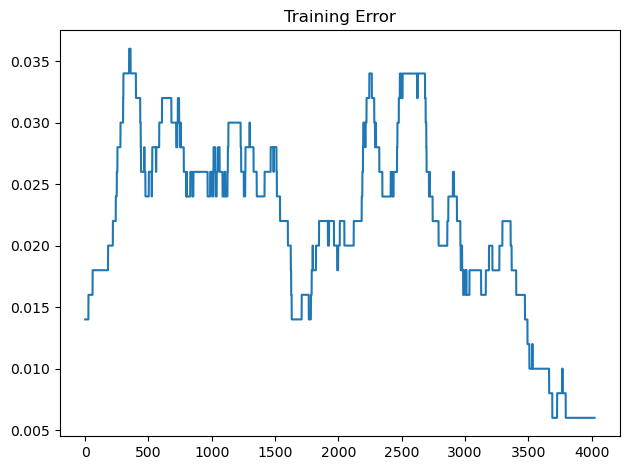

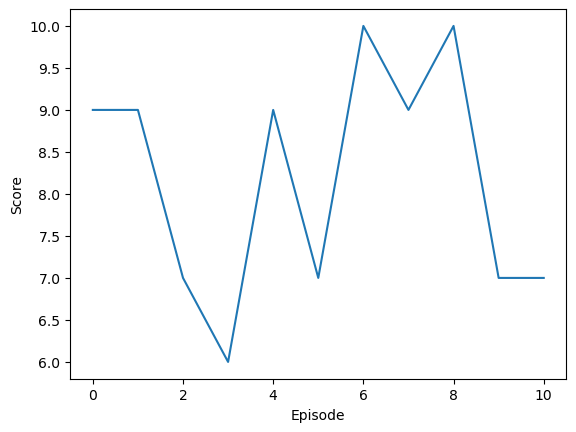

In [43]:
def main():
    # Path for ffmpeg
    os.environ['IMAGEIO_FFMPEG_EXE'] = "/opt/homebrew/bin/ffmpeg"
    
    # Create environment
    env = gym.make("ALE/Frogger-ram-v5", obs_type="ram", render_mode="rgb_array", difficulty=0)
    
    # Hyperparameters
    num_actions = env.action_space.n
    # Larger learning rate adjusts aggressively and may not converge
    lr = .001              
    n_episodes = 11
    # Larger epsilons encourage more exploring while training
    start_epsilon = 1.0
    final_epsilon = 0.00001
    
    # Reduce the agent's exploration over time 
    # We use linear decay
    epsilon_decay = (start_epsilon-final_epsilon) / n_episodes 
    
    # Create an Agent object with the above hyperparameters
    agent = Agent(num_actions = num_actions,
                  learning_rate = lr,
                  initial_epsilon = start_epsilon,
                  epsilon_decay = epsilon_decay,
                  final_epsilon = final_epsilon)

    
    # Start training
    env, rewards = train(env, n_episodes, agent, num_actions)
    
    # Visualize training
    visualize_training(env, agent)
    
    visualize_rewards(rewards)
    
    # Close environment
    env.close()
    
if __name__ == "__main__":
    main()

## Remarks

In this notebook we are only training for eleven episodes.  Additional examples from longer training times are attached in this github repository - we keep the training short in this notebook just so we can focus on the implementation and not on the end results.

Note that in video 

"rl-video-episode-10.mp4"

The agent is exploring quite a bit, and doesn't understand what the long term goal is yet.  

Then in video

"rl-video-episode-1000.mp4"

We can see that the agent is no longer exploring and understands that the long term goal of the game is to make it across the road.

---------------------------------------------------------------------
References

[1] Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction (2nd ed.). The MIT Press.

[2] Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Hassabis, D. (2013). Playing Atari with Deep Reinforcement Learning. In Advances in neural information processing systems (pp. 2672-2680).

